In [25]:
#include parent folder
import os, sys, inspect

currentdir = os.path.dirname(
    os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import time
import timeit
import numpy as np
import pytest
import jax
import jax.numpy as jnp
import functools
import scipy
import pandas as pd

from src.domain import Domain
from src.misc import *

In [26]:
def VLJ1(v, w):   
    r = jnp.linalg.norm(v-w) # euclidian distance between points
    return 4 * (4*pow(1 / r, 12) - 2*pow(1 / r, 6))

def VLJ2(v, w):
    r = jnp.linalg.norm(v-w) # euclidian distance between points
    r6 = pow(1 / r, 6)    # recycle exponents
    return (16*r6*r6 - 8*r6)

def VLJ3(r):
    return 4 * (4*pow(1 / r, 12) - 2*pow(1 / r, 6)) # TODO: numpy pow

VLJ1_jit = jax.jit(VLJ1)
VLJ2_jit = jax.jit(VLJ2)
VLJ3_jit = jax.jit(VLJ3)

def Epot_loops_nojit(pos): 
    # primitive Loop   
    v = to3D(pos)
    E = 0
    for i in range(len(v)):
        for j in range(i + 1, len(v)):
            E += VLJ1(v[i], v[j])    # using jit actually shaved off 20% form runtime  
    return E  

def Epot_loops_VLJ1_jit(v): 
    # primitive Loop   
    E = 0
    for i in range(len(v)):
        for j in range(i + 1, len(v)):
            E += VLJ1_jit(v[i], v[j])  
    return E 


def Epot_loops_VLJ2_jit(v): 
    # primitive Loop   
    E = 0
    for i in range(len(v)):
        for j in range(i + 1, len(v)):
            E += VLJ2_jit(v[i], v[j])   
    return E   

def Epot_broadcasted(x):
    n = len(x)
    broadcasted = x[:, np.newaxis, :] - x   # calculate the distance between all particles
    broadcasted = broadcasted.reshape(n*n,3)   # reshape such that we have a list of distance vectors
    dist = np.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    dist = dist[dist != 0]    # remove 0s
    E = 0
    for d in dist:
        E += VLJ3(d)

    return E /2

def Epot_broadcasted(x):
    n = len(x)
    broadcasted = x[:, np.newaxis, :] - x   # calculate the distance between all particles
    broadcasted = broadcasted.reshape(n*n,3)   # reshape such that we have a list of distance vectors
    dist = np.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    dist = dist[dist != 0]    # remove 0s
    E = 0
    for d in dist:
        E += VLJ3(d)

    return E /2


def Epot_broadcasted_jnp(x):
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles
    broadcasted = broadcasted.reshape(n*n,3)   # reshape such that we have a list of distance vectors
    dist = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    dist = dist[dist != 0]    # remove 0s
    E = 0
    for d in dist:
        E += VLJ3(d)

    return E /2

def Epot_vectorized(x):
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles
    broadcasted = broadcasted.reshape(n*n,3)   # reshape such that we have a list of distance vectors
    r = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    r = r[r != 0]    # remove 0s
    return 4 * (4*np.power(r, -12) - 2*np.power(r, -6)).sum() / 2 # TODO: numpy pow


def Epot_vectorized2(x):
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles while utilizing jnp.broadcast
    broadcasted = broadcasted.reshape(n*n,3)
    r = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    r6 =  jnp.nan_to_num(jnp.power(r, -6), posinf=0.0)
    return 4*(2*r6*r6 - r6).sum()

# Current Winner
def Epot_vectorized2_dot(x):
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles while utilizing jnp.broadcast
    broadcasted = broadcasted.reshape(n*n,3)
    r = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    r6 =  jnp.nan_to_num(jnp.power(r, -6), posinf=0.0)
    return 4*(2*jnp.dot(r6,r6) - r6.sum())


def Epot_vectorized3(x):
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles while utilizing jnp.broadcast
    broadcasted = broadcasted.reshape(n*n,3)
    broadcasted = broadcasted[(n*n)//2:]
    r = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    r6 =  jnp.nan_to_num(jnp.power(r, -6), posinf=0.0)
    return 8*(2*r6*r6 - r6).sum()

def Epot_vectorized4(x):
    n2 = len(x)*len(x)
    broadcasted = jnp.array(x[:, jnp.newaxis, :] - x)   # calculate the distance between all particles while utilizing jnp.broadcast
    broadcasted = broadcasted.reshape(n2,3) # to Nx3
    broadcasted = broadcasted[(n2)//2:]
    r = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    r6 =  jnp.nan_to_num(jnp.power(r, -6), posinf=0.0)
    return 8*(2*r6*r6 - r6).sum()


def Epot_vectorized_einsum(x):
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles while utilizing jnp.broadcast
    v = broadcasted.reshape(n*n,3)
    r = jnp.einsum("ij,ij->i",v,v)  # calculate squared norm
    r6 =  jnp.nan_to_num(jnp.power(r, -3), posinf=0.0)  # = (1/r²)^6
    return 4*(2*r6*r6 - r6).sum()


def Epot_montana(positions):
    """Lennard-Jones potential in reduced units.
    In this system of units, epsilon=1 and sigma=2**(-1. / 6.).
    """
    if positions.ndim != 2 or positions.shape[1] != 3:
        raise ValueError("positions must be an Mx3 array")
    # Compute all squared distances between pairs without iterating.
    delta = positions[:, np.newaxis, :] - positions
    r2 = (delta * delta).sum(axis=2)
    # Take only the upper triangle (combinations of two atoms).
    indices = np.triu_indices(r2.shape[0], k=1)
    rm2 = 1. / r2[indices]
    # Compute the potental energy recycling as many calculations as possible.
    rm6 = rm2 * rm2 * rm2
    rm12 = rm6 * rm6
    return (rm12 - 2. * rm6).sum()

def Epot_cdist(pos):
    return np.triu(scipy.spatial.distance.cdist(pos, pos, metric=VLJ1)).sum()

def Epot_cdist_jnp(pos):
    return jnp.triu(scipy.spatial.distance.cdist(pos, pos, metric=VLJ1)).sum()

Epot_loops_jit = jax.jit(Epot_loops_VLJ1_jit)
Epot_loops2_jit = jax.jit(Epot_loops_VLJ2_jit)
Epot_vectorized2_jit = jax.jit(Epot_vectorized2)    # Currenttly the fastest
Epot_vectorized3_jit = jax.jit(Epot_vectorized3)
Epot_vectorized4_jit = jax.jit(Epot_vectorized4)
Epot_vectorized_einsum_jit = jax.jit(Epot_vectorized_einsum)
Epot_vectorized2_dot_jit = jax.jit(Epot_vectorized2_dot)
Epot_montana_jit = jax.jit(Epot_montana)

In [27]:
def benchMark(domain, Epot_func, label="", n=5):
    result = Epot_func(domain.pos)  # call so that the jit compiler does not affect the benchmark

    timer = timeit.Timer(functools.partial(Epot_func, domain.pos))
    t = timer.timeit(n) / n # Rrepeat n times and take average
    """
    t = 0
    for i in range(n):
        start = time.time()
        Epot_func(domain.pos)
        end = time.time()
        t += (end - start)

    t = t /n
    """

    return pd.DataFrame(data={
        'time': [t], 
        'label': [label], 
        "result" : [result],
        "n_particles" : [len(domain.pos)],
        "size" : [domain.length]
        })

domain = Domain()
domain.fill(20,20,1, 1)
data = pd.DataFrame()

In [28]:
# slow  ones
n = 1
data = data.append(benchMark(domain, Epot_loops_nojit, "primitive loop, no jit", n))
data = data.append(benchMark(domain, Epot_loops_VLJ1_jit, "primitive loop, jit", n))

In [29]:
# fast ones but long compile time
n = 20
data = data.append(benchMark(domain, Epot_loops_jit, "loop, all jitted", n))
data = data.append(benchMark(domain, Epot_loops2_jit, "loops, all jitted, recycled exonents", n))

In [30]:
# broadcasted
n = 10
data = data.append(benchMark(domain, Epot_broadcasted, "broadcasted", n))
data = data.append(benchMark(domain, Epot_broadcasted_jnp, "broadcasted, jnp", n))

In [31]:
#vectocized
n = 100
data = data.append(benchMark(domain, Epot_vectorized, "vectorized", n))
data = data.append(benchMark(domain, Epot_vectorized2, "vectorized, recycled", n))
data = data.append(benchMark(domain, Epot_vectorized3, "vectorized, recycled, half slice", n))
data = data.append(benchMark(domain, Epot_vectorized4, "vectorized, compound, half slice", n))
data = data.append(benchMark(domain, Epot_vectorized_einsum, "vectorized, einsum", n))
data = data.append(benchMark(domain, Epot_vectorized2_jit, "vectorized, recycled, jit", n))
#data = data.append(benchMark(domain, Epot_vectorized3_jit, "vectorized, recycled, half, slice, jit", n))
#data = data.append(benchMark(domain, Epot_vectorized4_jit, "vectorized, compound, half slice, jit", n))
data = data.append(benchMark(domain, Epot_vectorized_einsum_jit, "vectorized, einsum, jit", n))
data = data.append(benchMark(domain, Epot_vectorized2_dot_jit, "vectorized, dot, jit", n))
data = data.append(benchMark(domain, Epot_montana, "Montaña", n))
data = data.append(benchMark(domain, Epot_montana_jit, "Montaña, jit", n))

In [32]:
# results
data = data.drop_duplicates(subset=["label"])
data = data.sort_values(by="time", ascending=False)
data

,time,label,result,n_particles,size
0,0.431404,"primitive loop, no jit",-0.028347962,20,20
0,0.020151,"primitive loop, jit",-0.028347962,20,20
0,0.002585,"broadcasted, jnp",-0.028348,20,20
0,0.001474,"vectorized, compound, half slice",-0.03104229,20,20
0,0.001062,"vectorized, einsum",-0.028347962,20,20
0,0.001032,"vectorized, recycled",-0.028347963,20,20
0,0.001011,"vectorized, recycled, half slice",-0.03104229,20,20
0,0.000912,vectorized,-0.028348,20,20
0,0.000763,broadcasted,-0.028348,20,20
0,0.000036,"loop, all jitted",-0.028347963,20,20


# Bigger Domain

In [33]:
domain = Domain()
domain.fill(1500,20,1)
data = pd.DataFrame()
n = 20


data = data.append(benchMark(domain, Epot_vectorized2_jit, "vectorized, recycled, jit", n))
#data = data.append(benchMark(domain, Epot_vectorized3_jit, "vectorized, recycled, half, slice, jit", n))
#data = data.append(benchMark(domain, Epot_vectorized4_jit, "vectorized, compound, half slice, jit", n))
data = data.append(benchMark(domain, Epot_vectorized_einsum_jit, "vectorized, einsum, jit", n))
data = data.append(benchMark(domain, Epot_vectorized2_dot_jit, "vectorized, dot, jit", n))
data = data.append(benchMark(domain, Epot_montana_jit, "Montaña", n))

data = data.drop_duplicates(subset=["label"])
data = data.sort_values(by="time", ascending=False)
data

TypeError: fill() missing 1 required positional argument: 'std_dev'

In [28]:

def Epot_vectorized_einsum(x):
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles while utilizing jnp.broadcast
    v = broadcasted.reshape(n*n,3)
    r = jnp.einsum("ij,ij->i",v,v)  # calculate squared norm
    r6 =  jnp.nan_to_num(jnp.power(r, -3), posinf=0.0)  # = (1/r²)^6
    return 4*(2*r6*r6 - r6).sum()

domain = Domain()
domain.fill(2,10,1)
print(Epot_vectorized3(domain.pos))
print(Epot_vectorized(domain.pos))

796991.9888693788
796991.9888693788


# detailed analysis of Epot_vectorized2

In [29]:
def Epot_vectorized2(x):
    df = pd.Series()

    start = time.time()
    n = len(x)
    end = time.time()
    df["len"] = end-start

    start = time.time()
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles while utilizing jnp.broadcast
    end = time.time()
    df["broadcast"] = end-start

    start = time.time()
    broadcasted = broadcasted.reshape(n*n,3)
    end = time.time()
    df["reshape"] = end-start

    start = time.time()
    r = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    end = time.time()
    df["norm"] = end-start

    start = time.time()
    r6 =  jnp.nan_to_num(jnp.power(r, -6), posinf=0.0)
    end = time.time()
    df["r6"] = end-start

    start = time.time()
    res = 4*(2*r6*r6 - r6).sum()
    end = time.time()
    df["res"] = end-start
    return df


domain = Domain()
domain.fill(200, 200, 1)
df = pd.DataFrame()
for i in range(100):
    df = df.append(Epot_vectorized2(domain.pos),ignore_index=True)

df.mean()

<ipython-input-29-2986ebbb10a8>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df = pd.Series()


broadcast    4.792786e-04
len          6.747246e-07
norm         1.045728e-04
r6           1.007180e-03
res          1.358404e-03
reshape      2.765656e-06
dtype: float64

In [30]:
def Epot_vectorized2(x):
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles while utilizing jnp.broadcast
    broadcasted = broadcasted.reshape(n*n,3)
    r = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    r6 =  jnp.nan_to_num(jnp.power(r, -6), posinf=0.0)
    return 4*(2*r6*r6 - r6).sum()

def Epot_vectorized_dot(x):
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles while utilizing jnp.broadcast
    broadcasted = broadcasted.reshape(n*n,3)
    r = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    r6 =  jnp.nan_to_num(jnp.power(r, -6), posinf=0.0)
    return 4*(2*jnp.dot(r6,r6) - r6.sum())

domain = Domain()
domain.fill(200, 200, 1)
print(Epot_vectorized2(domain.pos))
print(Epot_vectorized_dot(domain.pos))

1.2063084442038974e+25
1.2063084442038836e+25


In [31]:
def Epot_vectorized_lin(x):
    x = to3D(x)
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles while utilizing jnp.broadcast
    broadcasted = broadcasted.reshape(n*n,3)
    r = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    r6 =  jnp.nan_to_num(jnp.power(r, -6), posinf=0.0)
    return 4*(2*r6*r6 - r6).sum()


def Epot_vectorized2(x):
    n = len(x)
    broadcasted = x[:, jnp.newaxis, :] - x   # calculate the distance between all particles while utilizing jnp.broadcast
    broadcasted = broadcasted.reshape(n*n,3)
    r = jnp.linalg.norm(broadcasted, axis=1)  # calculate the euclidian norm of all distances
    r6 =  jnp.nan_to_num(jnp.power(r, -6), posinf=0.0)
    return 4*(2*r6*r6 - r6).sum()

np.random.seed(1)
domain = Domain()
domain.fill(10, 20, 1)
print(Epot_vectorized_lin(domain.pos.ravel()))
print(Epot_vectorized_lin(domain.pos))
print(Epot_vectorized2(domain.pos))
type(domain.pos[0][0])

135564519.06590313
135564519.06590313
135564519.06590313


numpy.float64

In [32]:
import matplotlib.pyplot as plt
E_vals = []
L_vals = np.linspace(14,40,100)
for L in L_vals:
    np.random.seed(1)
    domain = Domain()
    domain.fill(20, L, 1)  
    E_vals.append(domain.Epot(domain.pos))

plt.plot(L_vals,E_vals)
plt.x_label()
plt.grid()

AttributeError: module 'matplotlib.pyplot' has no attribute 'x_label'

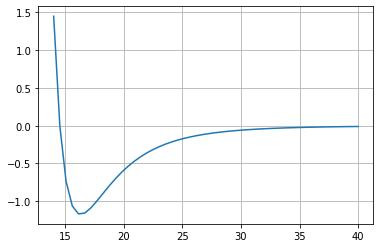

In [30]:
import matplotlib.pyplot as plt
E_vals = []
n_vals = range(8,16)
for L in L_vals:
    np.random.seed(1)
    domain = Domain()
    domain.fill(20, L, 1)  
    E_vals.append(domain.Epot(domain.pos))

plt.plot(L_vals,E_vals)
plt.grid()

In [42]:

data = pd.DataFrame()
n_vals = list(range(1,30))
for n in n_vals:
    domain = Domain()
    domain.fill(n,20,1, 1)


    data = data.append(benchMark(domain, Epot_loops_nojit, "", n))
data

,time,label,result,n_particles,size
0,0.000145,,0,1,20
0,0.002363,,-0.00011651808,2,20
0,0.007288,,-5.087674e-05,3,20
0,0.013186,,-0.0046864464,4,20
0,0.022041,,-0.0003056219,5,20
0,0.035088,,-0.00050497,6,20
0,0.049925,,-0.0023295258,7,20
0,0.063370,,-0.0018563541,8,20
0,0.081884,,-0.028779186,9,20
0,0.103700,,-0.11123018,10,20
